# Variance-Aware Smoothing for Survey KPIs

## Overview

This notebook demonstrates a principled approach to smoothing time series survey data that accounts for varying sample sizes and measurement uncertainty across time periods.

### The Problem

Weekly or monthly survey KPIs exhibit noise because each period has finite (and often varying) sample size $n_t$. This sampling error:
- Adds variance without adding information
- Creates noisy dashboards and unstable trends
- Makes period-to-period comparisons difficult

**Key insight:** Not all observations are equally reliable. A month with $n=50$ respondents should be smoothed more than a month with $n=500$.

### Our Approach

We use **Kalman smoothing** with period-specific measurement variance to:
1. Estimate measurement uncertainty for each period based on effective sample size
2. Apply optimal smoothing that adapts to data quality
3. Provide uncertainty bands for the smoothed estimates

### Mathematical Framework

#### Step 1: Weighted Mean and Measurement Variance

For each time period $t$, from individual microdata $(y_{it}, w_{it})$:

**Weighted mean:**
$$\hat{y}_t = \frac{\sum_i w_{it} y_{it}}{\sum_i w_{it}}$$

**Effective sample size** (accounts for unequal weights):
$$n_{\text{eff},t} = \frac{(\sum_i w_{it})^2}{\sum_i w_{it}^2}$$

**Weighted sample variance** (Bessel-corrected):
$$s_{w,t}^2 = \frac{\sum_i w_{it}(y_{it} - \hat{y}_t)^2}{\sum_i w_{it} - \frac{\sum_i w_{it}^2}{\sum_i w_{it}}}$$

**Measurement variance of the mean:**
$$H_t = \text{Var}(\hat{y}_t) \approx \frac{s_{w,t}^2}{n_{\text{eff},t}}$$

This gives us period-specific uncertainty: small $n_{\text{eff},t}$ → large $H_t$ → more smoothing.

#### Step 2: State Space Model (Kalman Filter/Smoother)

We model the true KPI $\mu_t$ as a slowly evolving local level:

**Observation equation:**
$$y_t = \mu_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, H_t)$$

**State equation:**
$$\mu_t = \mu_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, Q)$$

Where:
- $H_t$: measurement variance (from survey sampling, varies by period)
- $Q$: process variance (how much the true signal can change month-to-month)

#### Step 3: Maximum Likelihood Estimation of Q

Rather than fixing the signal-to-noise ratio, we estimate $Q$ using maximum likelihood estimation (MLE). This approach:
- Uses the observed data to find the optimal process variance
- Automatically balances smoothness vs fit to the data
- Provides a more data-driven solution

The MLE approach maximizes the log-likelihood of the observed data under the state space model, finding the value of $Q$ that best explains the patterns in the data given the known measurement variances $H_t$.

### Data: University of Michigan Index of Consumer Sentiment

We'll use the monthly ICS data which includes:
- Individual response microdata with survey weights
- Published aggregate index values

This is an ideal test case because we can:
1. Calculate weighted means ourselves
2. Estimate measurement variance from effective sample size
3. Apply our smoothing procedure
4. Compare to published values

## 1. Load Data and Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

print("Libraries loaded successfully!")

Libraries loaded successfully!


### Load Data from GitHub

We'll load two datasets:
1. **Individual microdata** (`AAk7MRJC.csv`): Individual survey responses with weights
2. **Published aggregate** (`scaum-479.csv`): Official monthly ICS values

In [ ]:
# URLs (GitHub raw content)
URL_PUBLISHED  = "https://raw.githubusercontent.com/oysteinm/smood/refs/heads/main/scaum-479.csv"
URL_INDIVIDUAL = "https://raw.githubusercontent.com/oysteinm/smood/refs/heads/main/AAk7MRJC.csv"

# Load published aggregate data
ics_month = pd.read_csv(URL_PUBLISHED)
ics_month["date"] = pd.to_datetime(ics_month["yyyymm"], format="%Y%m", errors="coerce")
ics_month["ics_all"] = pd.to_numeric(ics_month["ics_all"], errors="coerce")
ics_data = ics_month[["date", "ics_all"]].rename(columns={"ics_all": "ics_published"})

print(f"Published data loaded: {len(ics_data)} months")
print(f"Date range: {ics_data['date'].min()} to {ics_data['date'].max()}")
ics_data.head()

Published data loaded: 572 months
Date range: 1978-01-01 00:00:00 to 2025-08-01 00:00:00


,date,ics_published
0,1978-01-01,83.7
1,1978-02-01,84.3
2,1978-03-01,78.8
3,1978-04-01,81.6
4,1978-05-01,82.9


In [ ]:
# Load individual microdata
ics_id = pd.read_csv(URL_INDIVIDUAL)
ics_id.columns = (
    ics_id.columns.str.strip()
    .str.lower()
    .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
)

# Expect YYYYMM, id, ics, wt
ics_id["date"] = pd.to_datetime(ics_id["yyyymm"], format="%Y%m", errors="coerce")
ics_id["ics"] = pd.to_numeric(ics_id["ics"], errors="coerce")
ics_id["wt"]  = pd.to_numeric(ics_id["wt"], errors="coerce")

print(f"\nIndividual microdata loaded: {len(ics_id)} responses")
print(f"Unique months: {ics_id['date'].nunique()}")
ics_id.head()

/tmp/ipython-input-2761636610.py:2: DtypeWarning: Columns (14,15,16,17,18,19,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  ics_id = pd.read_csv(URL_INDIVIDUAL)



Individual microdata loaded: 336373 responses
Unique months: 573


,caseid,yyyymm,yyyyq,yyyy,id,idprev,datepr,idprev2,datepr2,sample,...,pinc2,pjob,pssa,pcry,pstk,polaff,wt,wt_hh,wt_quintmed,date
0,1,197801,19781,1978,1,,,,,1,...,,,,,,,0.00,,,1978-01-01
1,2,197801,19781,1978,2,,,,,1,...,,,,,,,0.72,,,1978-01-01
2,3,197801,19781,1978,3,,,,,1,...,,,,,,,1.03,,,1978-01-01
3,4,197801,19781,1978,4,,,,,1,...,,,,,,,0.00,,,1978-01-01
4,5,197801,19781,1978,5,,,,,1,...,,,,,,,0.93,,,1978-01-01


## 2. Calculate Monthly Weighted Means and Measurement Variance

For each month, we compute:
- Weighted mean of ICS
- Effective sample size (accounting for unequal weights)
- Weighted variance
- Measurement variance (standard error of the mean)

In [ ]:
def monthly_stats(df):
    """Calculate weighted monthly statistics for survey data."""
    d = df.loc[np.isfinite(df["ics"]) & np.isfinite(df["wt"]) & (df["wt"] > 0)].copy()

    # Group-wise weighted mean, n_eff, var
    out = []
    for date, g in d.groupby("date"):
        w = g["wt"].to_numpy()
        x = g["ics"].to_numpy()
        n = len(x)
        w_sum  = w.sum()
        w2_sum = (w**2).sum()

        # Effective sample size
        n_eff  = (w_sum**2) / max(w2_sum, 1e-12)

        # Weighted mean
        xhat   = (w * x).sum() / w_sum

        # Bessel-corrected weighted variance
        denom  = max(w_sum - (w2_sum / w_sum), 1e-8)
        s2_w   = (w * (x - xhat)**2).sum() / denom

        # Variance of the mean and standard error
        var_mean = s2_w / max(n_eff, 1e-8)
        se_mean  = np.sqrt(max(var_mean, 1e-12))

        out.append((date, n, n_eff, w_sum, w2_sum, xhat, s2_w, var_mean, se_mean))

    return pd.DataFrame(
        out, columns=["date", "n", "n_eff", "w_sum", "w2_sum",
                      "ics_hat", "s2_w", "var_mean", "se_mean"]
    ).sort_values("date").reset_index(drop=True)

# Calculate monthly statistics
ics_monthly = monthly_stats(ics_id)

print(f"Monthly statistics calculated for {len(ics_monthly)} months")
print(f"\nSample size statistics:")
print(f"  Median n_eff: {ics_monthly['n_eff'].median():.1f}")
print(f"  Min n_eff: {ics_monthly['n_eff'].min():.1f}")
print(f"  Max n_eff: {ics_monthly['n_eff'].max():.1f}")

ics_monthly.head()

Monthly statistics calculated for 573 months

Sample size statistics:
  Median n_eff: 433.8
  Min n_eff: 331.8
  Max n_eff: 1120.1


,date,n,n_eff,w_sum,w2_sum,ics_hat,s2_w,var_mean,se_mean
0,1978-01-01,600,409.277434,600.31,880.5081,83.741139,1324.329889,3.235775,1.798826
1,1978-02-01,1135,593.741645,1133.24,2162.9490,84.280458,1201.435498,2.023499,1.422497
2,1978-03-01,707,458.781881,708.50,1094.1414,78.795184,1282.641212,2.795754,1.672051
3,1978-04-01,663,462.622347,662.00,947.3040,81.632066,1336.568884,2.889114,1.699740
4,1978-05-01,1185,596.901981,1185.28,2353.6338,82.861965,1247.015474,2.089146,1.445388


### Visualize Sample Size and Measurement Variance Over Time

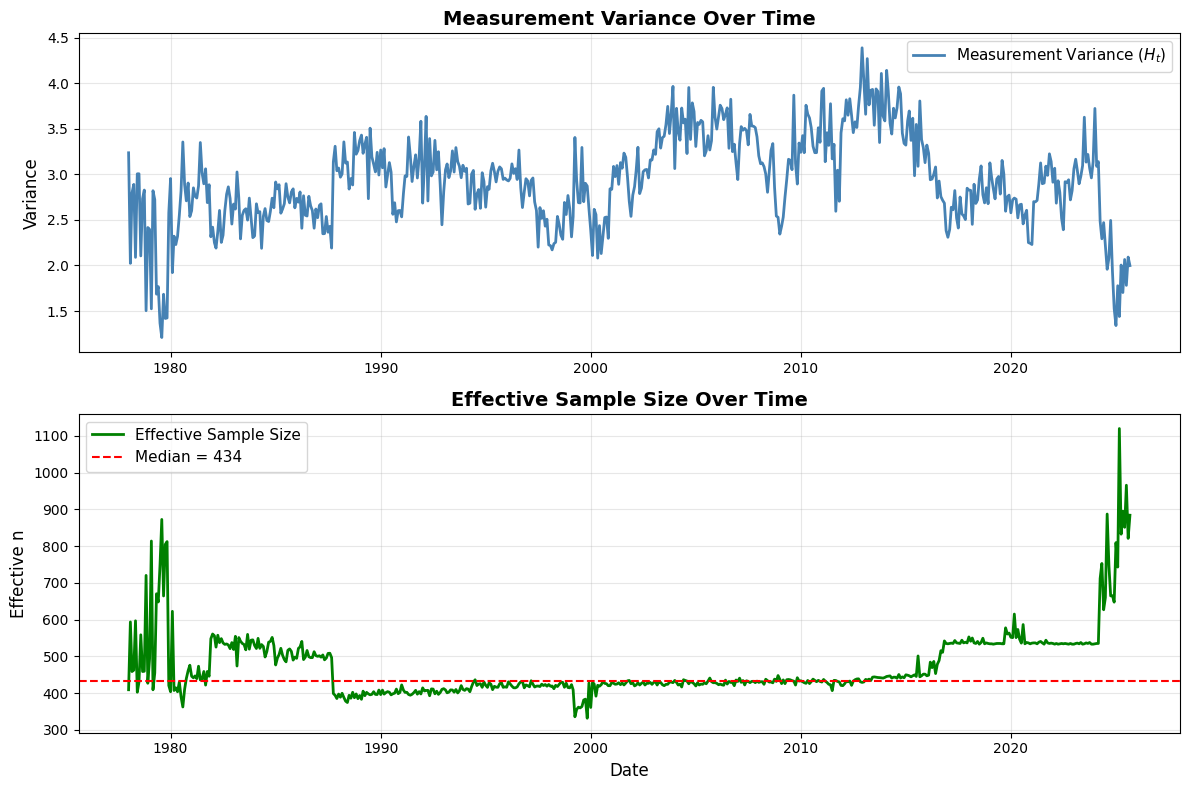

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top panel: Measurement variance (H_t)
ax1.plot(ics_monthly['date'], ics_monthly['var_mean'],
         linewidth=2, color='steelblue', label='Measurement Variance ($H_t$)')
ax1.set_ylabel('Variance', fontsize=12)
ax1.set_title('Measurement Variance Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom panel: Effective sample size over time
ax2.plot(ics_monthly['date'], ics_monthly['n_eff'],
         linewidth=2, color='green', label='Effective Sample Size')
ax2.axhline(y=ics_monthly['n_eff'].median(), color='red',
            linestyle='--', label=f'Median = {ics_monthly["n_eff"].median():.0f}')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Effective n', fontsize=12)
ax2.set_title('Effective Sample Size Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Kalman Smoothing with MLE-Estimated Process Variance

Now we apply the Kalman filter/smoother using the **local level model** with:
- Time-varying measurement variance $H_t$ (from our calculations above)
- Process variance $Q$ estimated via maximum likelihood estimation (MLE)

### Prepare Measurement Variance H_t

We need to ensure all measurement variances are positive and handle any missing values.

In [ ]:
# Extract measurement variance and observations
H = ics_monthly["var_mean"].to_numpy().astype(float)
y = ics_monthly["ics_hat"].to_numpy().astype(float)

# Guard for H_t: ensure all values are positive and finite
good = np.isfinite(H) & (H > 0)
fallback = np.nanmedian(H[good]) if np.any(good) else (np.nanvar(y) * 0.05)
if not np.isfinite(fallback):
    fallback = np.nanvar(y) * 0.05
H[~good] = fallback

# Apply a floor to prevent extremely small variances
q05 = np.nanquantile(H, 0.05) if np.isfinite(np.nanquantile(H, 0.05)) else np.nan
floor_val = 0.1 * q05 if (np.isfinite(q05) and q05 > 0) else 0.1 * fallback
H = np.maximum(H, floor_val)

print(f"Measurement variance (H_t) statistics:")
print(f"  Mean: {H.mean():.6f}")
print(f"  Median: {np.median(H):.6f}")
print(f"  Min: {H.min():.6f}")
print(f"  Max: {H.max():.6f}")

Measurement variance (H_t) statistics:
  Mean: 2.933419
  Median: 2.938169
  Min: 1.210125
  Max: 4.386874


### Kalman Filter Log-Likelihood

We implement the Kalman filter to compute the log-likelihood of the data given parameters $Q$ and $H_t$.

In [ ]:
def kalman_loglike(y, H, Q, P0=1e6):
    """Local level model log-likelihood (handles missing y)."""
    T = len(y)
    mu_pred = 0.0
    P_pred = P0 + Q
    ll = 0.0

    for t in range(T):
        yt = y[t]
        Ht = H[t]

        if np.isfinite(yt):
            # Innovation variance
            S = P_pred + Ht
            S = np.maximum(S, 1e-8)

            # Innovation
            v = yt - mu_pred

            # Log-likelihood contribution
            ll -= 0.5 * (np.log(2*np.pi) + np.log(S) + (v*v)/S)

            # Kalman gain and update
            K = P_pred / S
            mu_filt = mu_pred + K*v
            P_filt = (1 - K) * P_pred
        else:
            # Skip update for missing observations
            mu_filt = mu_pred
            P_filt = P_pred

        # Predict next time step
        mu_pred = mu_filt
        P_pred  = P_filt + Q

    return ll

### Maximum Likelihood Estimation of Q

We use numerical optimization to find the value of $Q$ that maximizes the log-likelihood.

In [ ]:
def estimate_Q_mle(y, H, q0=None):
    """Estimate Q via maximum likelihood."""
    if q0 is None:
        q0 = np.nanmean(H) * 0.05
        if not np.isfinite(q0) or q0 <= 0:
            q0 = np.nanvar(y) * 0.05

    # Optimize in log-space to ensure Q > 0
    def nll(logQ):
        Q = np.exp(logQ)
        return -kalman_loglike(y, H, Q)

    res = minimize(nll, x0=np.log(q0), method="L-BFGS-B")
    return float(np.exp(res.x)), res

# Estimate Q
Q_hat, res = estimate_Q_mle(y, H)
print(f"\nEstimated process variance (Q): {Q_hat:.6g}")
print(f"Optimization converged: {res.success}")
print(f"Log-likelihood: {-res.fun:.2f}")


Estimated process variance (Q): 12.0576
Optimization converged: True
Log-likelihood: -1625.35


/tmp/ipython-input-378650577.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.exp(res.x)), res


### Kalman Filter (Forward Pass)

Store the filtered estimates at each time point.

In [ ]:
def kalman_filter_store(y, H, Q, P0=1e6):
    """Run Kalman filter and store all intermediate values."""
    T = len(y)
    mu_pred = np.zeros(T)
    P_pred  = np.zeros(T)
    mu_filt = np.zeros(T)
    P_filt  = np.zeros(T)

    # Initial prediction
    mu_pred[0] = 0.0
    P_pred[0]  = P0 + Q

    # Filter first observation
    if np.isfinite(y[0]):
        S = P_pred[0] + H[0]
        S = max(S, 1e-8)
        K = P_pred[0] / S
        v = y[0] - mu_pred[0]
        mu_filt[0] = mu_pred[0] + K*v
        P_filt[0]  = (1 - K) * P_pred[0]
    else:
        mu_filt[0] = mu_pred[0]
        P_filt[0]  = P_pred[0]

    # Filter remaining observations
    for t in range(1, T):
        mu_pred[t] = mu_filt[t-1]
        P_pred[t]  = P_filt[t-1] + Q

        if np.isfinite(y[t]):
            S = P_pred[t] + H[t]
            S = max(S, 1e-8)
            K = P_pred[t] / S
            v = y[t] - mu_pred[t]
            mu_filt[t] = mu_pred[t] + K*v
            P_filt[t]  = (1 - K) * P_pred[t]
        else:
            mu_filt[t] = mu_pred[t]
            P_filt[t]  = P_pred[t]

    return mu_pred, P_pred, mu_filt, P_filt

### RTS Smoother (Backward Pass)

Apply the Rauch-Tung-Striebel (RTS) smoother to get smoothed estimates using all available data.

In [ ]:
def rts_smoother(mu_pred, P_pred, mu_filt, P_filt, Q):
    """Apply RTS smoother backward pass."""
    T = len(mu_filt)
    mu_smooth = np.zeros(T)
    P_smooth  = np.zeros(T)

    # Initialize with filtered values at last time point
    mu_smooth[-1] = mu_filt[-1]
    P_smooth[-1]  = P_filt[-1]

    # Backward pass
    for t in range(T-2, -1, -1):
        denom = P_pred[t+1]
        denom = np.maximum(denom, 1e-8)
        J = P_filt[t] / denom
        mu_smooth[t] = mu_filt[t] + J*(mu_smooth[t+1] - mu_pred[t+1])
        P_smooth[t]  = P_filt[t] + (J**2)*(P_smooth[t+1] - P_pred[t+1])

    return mu_smooth, P_smooth

### Run Kalman Filter and Smoother

In [ ]:
# Run filter
mu_pred, P_pred, mu_filt, P_filt = kalman_filter_store(y, H, Q_hat)

# Run smoother
mu_smooth, P_smooth = rts_smoother(mu_pred, P_pred, mu_filt, P_filt, Q_hat)

# Calculate standard errors
se_smooth = np.sqrt(np.maximum(P_smooth, 0.0))

print("Kalman filter and smoother completed successfully!")

Kalman filter and smoother completed successfully!


## 4. Results and Visualization

In [ ]:
# Combine results
out = ics_monthly.copy()
out["ics_sm"]    = mu_smooth
out["ics_sm_lo"] = mu_smooth - 1.96 * se_smooth
out["ics_sm_hi"] = mu_smooth + 1.96 * se_smooth

# Join with published index
ics_cmp = out.merge(ics_data, on="date", how="left")

print("\nFinal dataset with smoothed values:")
print(f"  Total months: {len(ics_cmp)}")
print(f"  Date range: {ics_cmp['date'].min()} to {ics_cmp['date'].max()}")

ics_cmp[["date", "ics_hat", "ics_sm", "ics_sm_lo", "ics_sm_hi", "ics_published"]].head(10)


Final dataset with smoothed values:
  Total months: 573
  Date range: 1978-01-01 00:00:00 to 2025-09-01 00:00:00


,date,ics_hat,ics_sm,ics_sm_lo,ics_sm_hi,ics_published
0,1978-01-01,83.741139,83.726374,80.552438,86.900311,83.7
1,1978-02-01,84.280458,83.672364,81.201083,86.143645,84.3
2,1978-03-01,78.795184,79.994838,77.220547,82.769130,78.8
3,1978-04-01,81.632066,81.491231,78.684559,84.297903,81.6
4,1978-05-01,82.861965,82.399850,79.903679,84.896021,82.9
5,1978-06-01,79.976564,80.641344,77.793352,83.489336,80.0
6,1978-07-01,82.421317,81.550184,78.701835,84.398534,82.4
7,1978-08-01,78.349864,78.964436,76.461992,81.466880,78.4
8,1978-09-01,80.389511,79.898982,77.147135,82.650830,80.4
9,1978-10-01,79.314871,78.669613,75.892123,81.447104,79.3


### Plot Raw vs Smoothed ICS with 95% Confidence Band

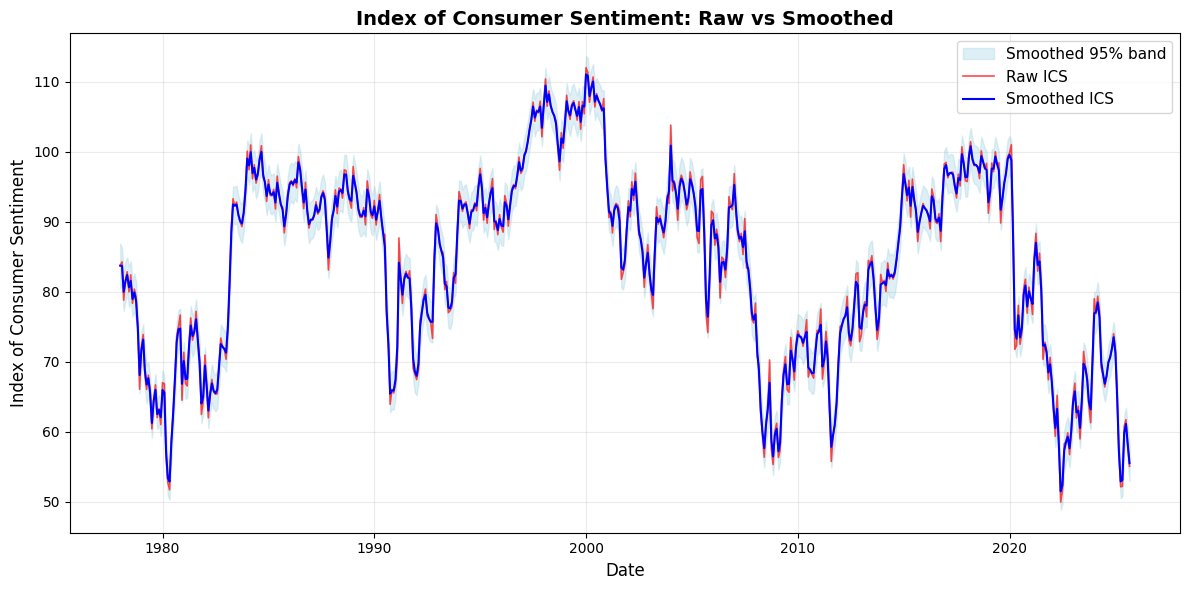

In [ ]:
plt.figure(figsize=(12, 6))

# 95% confidence band
plt.fill_between(ics_cmp["date"], ics_cmp["ics_sm_lo"], ics_cmp["ics_sm_hi"],
                 color="lightblue", alpha=0.4, label="Smoothed 95% band")

# Raw ICS
plt.plot(ics_cmp["date"], ics_cmp["ics_hat"],
         color="red", label="Raw ICS", linewidth=1.2, alpha=0.7)

# Smoothed ICS
plt.plot(ics_cmp["date"], ics_cmp["ics_sm"],
         color="blue", label="Smoothed ICS", linewidth=1.5)

plt.title("Index of Consumer Sentiment: Raw vs Smoothed", fontsize=14, fontweight='bold')
plt.ylabel("Index of Consumer Sentiment", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## 5. Diagnostics and Validation

Let's examine how well the smoothed series tracks the raw observations.

In [ ]:
# Calculate correlations
valid = np.isfinite(ics_cmp["ics_hat"]) & np.isfinite(ics_cmp["ics_sm"])

corr_raw_sm = np.corrcoef(ics_cmp.loc[valid, "ics_hat"],
                          ics_cmp.loc[valid, "ics_sm"])[0,1]

corr_round1 = np.corrcoef(np.round(ics_cmp.loc[valid, "ics_hat"], 1),
                          np.round(ics_cmp.loc[valid, "ics_sm"], 1))[0,1]

print("Diagnostics:")
print(f"  Correlation (raw vs smoothed): {corr_raw_sm:.6f}")
print(f"  Correlation (1-decimal rounding): {corr_round1:.6f}")

# Summary statistics
print("\nSummary Statistics:")
print(f"  Raw ICS mean: {ics_cmp['ics_hat'].mean():.2f}")
print(f"  Raw ICS std: {ics_cmp['ics_hat'].std():.2f}")
print(f"  Smoothed ICS mean: {ics_cmp['ics_sm'].mean():.2f}")
print(f"  Smoothed ICS std: {ics_cmp['ics_sm'].std():.2f}")
print(f"  Noise reduction: {(1 - ics_cmp['ics_sm'].std()/ics_cmp['ics_hat'].std())*100:.1f}%")

Diagnostics:
  Correlation (raw vs smoothed): 0.998028
  Correlation (1-decimal rounding): 0.998030

Summary Statistics:
  Raw ICS mean: 84.30
  Raw ICS std: 13.54
  Smoothed ICS mean: 84.31
  Smoothed ICS std: 13.38
  Noise reduction: 1.2%


### Compare with Published Index


Correlation with published index: 0.998016


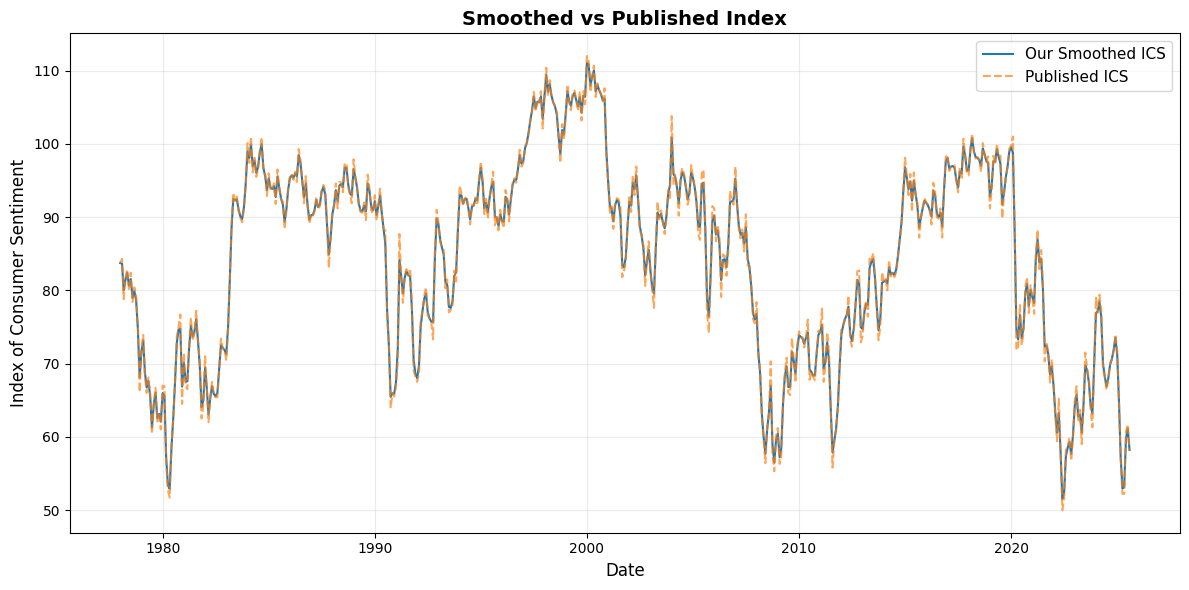

In [ ]:
# Compare with published index if available
valid_pub = np.isfinite(ics_cmp["ics_published"]) & valid

if valid_pub.sum() > 0:
    corr_smooth_pub = np.corrcoef(ics_cmp.loc[valid_pub, "ics_sm"],
                                  ics_cmp.loc[valid_pub, "ics_published"])[0,1]

    print(f"\nCorrelation with published index: {corr_smooth_pub:.6f}")

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(ics_cmp.loc[valid_pub, "date"],
             ics_cmp.loc[valid_pub, "ics_sm"],
             label="Our Smoothed ICS", linewidth=1.5)
    plt.plot(ics_cmp.loc[valid_pub, "date"],
             ics_cmp.loc[valid_pub, "ics_published"],
             label="Published ICS", linewidth=1.5, linestyle='--', alpha=0.7)
    plt.title("Smoothed vs Published Index", fontsize=14, fontweight='bold')
    plt.ylabel("Index of Consumer Sentiment", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo published index data available for comparison.")

## Summary

This notebook demonstrated variance-aware Kalman smoothing for survey data:

1. **Computed measurement variance** from weighted microdata accounting for effective sample size
2. **Estimated process variance Q** using maximum likelihood estimation
3. **Applied Kalman filter and RTS smoother** to obtain optimal smoothed estimates
4. **Provided uncertainty quantification** through 95% confidence bands

The approach automatically adapts smoothing intensity based on data quality, providing more smoothing when sample sizes are small and less smoothing when sample sizes are large.